In [2]:
import os
import sys
import numpy as np
import glob
import pandas as pd
import shutil
import gzip
import nibabel
import scipy.io
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import vec_to_sym_matrix
import scipy.stats
import utils
import math

# Subtype Analysis

In [3]:
df = pd.read_csv('./Final/Subtype_Info.csv')
df.head()

,Unnamed: 0,GIFT_Index,SUB_ID,SUB_TYPE
0,170,171,50659,0
1,171,172,50664,0
2,172,173,50666,0
3,173,174,51064,0
4,174,175,51065,0


In [4]:
TD_idx = np.array(range(170,365), dtype = 'uint32') #Python Indices
Autistic_idx = np.array(df[df['SUB_TYPE'] == 1]['GIFT_Index'].values, dtype = 'uint32') - 1 
Aspergers_idx = np.array(df[df['SUB_TYPE'] == 2]['GIFT_Index'].values, dtype = 'uint32') - 1
PDDNOS_idx = np.array(df[df['SUB_TYPE'] == 3]['GIFT_Index'].values, dtype = 'uint32') - 1

print('Number of TD samples : ', len(TD_idx))
print('Number of Autistic samples : ', len(Autistic_idx))
print('Number of Aspergers samples : ', len(Aspergers_idx))
print('Number of PDDNOS samples : ', len(PDDNOS_idx))

Number of TD samples :  195
Number of Autistic samples :  115
Number of Aspergers samples :  28
Number of PDDNOS samples :  12


In [9]:
n_states = 4
n_windows_per_sub = 130
groups = {'TD' : TD_idx, 'Autistic' : Autistic_idx, 'Aspergers' : Aspergers_idx, 'PDD' : PDDNOS_idx}
group_names = list(groups.keys())
print('Groups : ', group_names)

Groups :  ['TD', 'Autistic', 'Aspergers', 'PDD']


## Distribution of Windows per state per group 

In [10]:
pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat')
pp.keys()

<ipython-input-10-6af6c812f6c8>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat')


<KeysViewHDF5 ['#refs#', 'FNCamp', 'FNCcm', 'clusterInfo', 'meta_states_info', 'tvdfncInfo']>

In [11]:
states = pp['clusterInfo']['states']
states = np.squeeze(states, 1)
print('State array shape : ', states.shape)
print('Number of windows')
for group in group_names : 
    print(f'{group} : ', np.unique(states[:, groups[group]], return_counts=True))
    print('_' * 10)


State array shape :  (130, 365)
Number of windows
TD :  (array([1., 2., 3., 4.]), array([17729,  2140,  1143,  4338]))
__________
Autistic :  (array([1., 2., 3., 4.]), array([10393,   828,   954,  2775]))
__________
Aspergers :  (array([1., 2., 3., 4.]), array([2566,  308,   99,  667]))
__________
PDD :  (array([1., 3., 4.]), array([1208,    4,  348]))
__________


## Two Sample-T test

In [12]:
cs = scipy.io.loadmat('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/Stats_K4/CPAC_NFNG__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(365, 1378, 4)

In [15]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
f1, p1 = utils.anova(dfnc_dict, state = 0)
# t2, p2 = utils.anova(dfnc_dict, state = 1)
f3, p3 = utils.anova(dfnc_dict, state = 2)
f4, p4 = utils.anova(dfnc_dict, state = 3)
print('T-Values shape : ', f1.shape)
print('P-Values shape : ', p1.shape)

State :  1
Group : TD and DFNC shape : (156, 1378)
Group : Autistic and DFNC shape : (93, 1378)
Group : Aspergers and DFNC shape : (23, 1378)
Group : PDD and DFNC shape : (10, 1378)
------------------------------------------------
State :  2
Group : TD and DFNC shape : (26, 1378)
Group : Autistic and DFNC shape : (12, 1378)
Group : Aspergers and DFNC shape : (4, 1378)
Group : PDD and DFNC shape : (0,)
------------------------------------------------
State :  3
Group : TD and DFNC shape : (15, 1378)
Group : Autistic and DFNC shape : (13, 1378)
Group : Aspergers and DFNC shape : (1, 1378)
Group : PDD and DFNC shape : (1, 1378)
------------------------------------------------
State :  4
Group : TD and DFNC shape : (65, 1378)
Group : Autistic and DFNC shape : (36, 1378)
Group : Aspergers and DFNC shape : (10, 1378)
Group : PDD and DFNC shape : (6, 1378)
------------------------------------------------
T-Values shape :  (1378,)
P-Values shape :  (1378,)


**State2 didn't occur in any of the PDDNOS(group4) subjects**
Therefore, Doing anova only on the TD, Autistic and Aspergers

In [17]:
f2, p2 = [], []
for i in range(1378):
    group1 = dfnc_dict[1][group_names[0]][:, i]
    group2 = dfnc_dict[1][group_names[1]][:, i]
    group3 = dfnc_dict[1][group_names[2]][:, i]
    f, p = scipy.stats.f_oneway(group1, group2, group3)
    f2.append(f)
    p2.append(p)
f2 = np.array(f2, dtype = 'float64')
p2 = np.array(p2, dtype = 'float64')
print('F-Values shape : ', f2.shape)
print('P-Values shape : ', p2.shape)

F-Values shape :  (1378,)
P-Values shape :  (1378,)


Concatenated p-values shape :  (4, 1378)


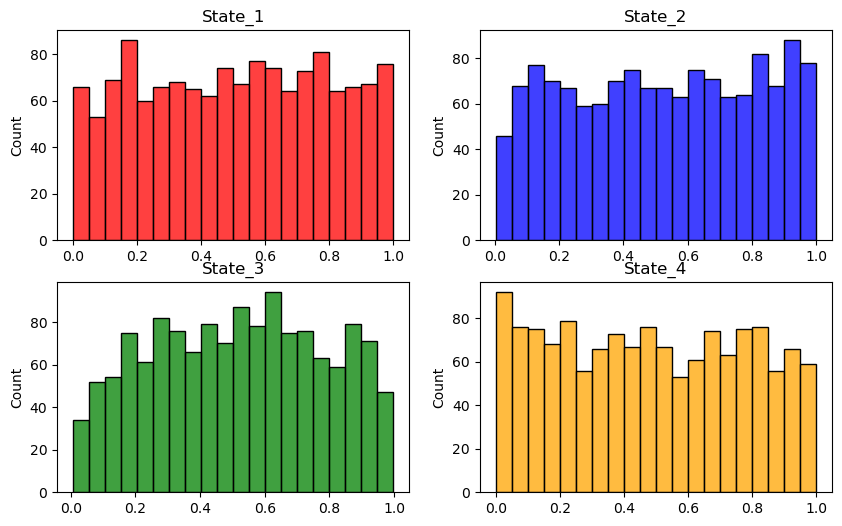

In [18]:
p = np.vstack([p1, p2, p3, p4])
print('Concatenated p-values shape : ', p.shape)    # n_states, 1378
labels = ['State_1', 'State_2', 'State_3', 'State_4']
utils.hist_plot(p, labels)

In [19]:
print('Number of connectivities with p values less than 0.05', (p1 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p2 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p3 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p4 < 0.05).sum())

Number of connectivities with p values less than 0.05 66
Number of connectivities with p values less than 0.05 38
Number of connectivities with p values less than 0.05 28
Number of connectivities with p values less than 0.05 92


## POC PLot of ASD and TD

States array shape :  (130, 365)
States values :  [1 2 3 4]
['TD', 'Autistic', 'Aspergers', 'PDD']
Number of groups :  4
Group names : ['TD', 'Autistic', 'Aspergers', 'PDD']
Shape of Mean value of occurences array shape :  (4, 4)
Shape of STD value of occurences array shape :  (4, 4)


/home/krishna/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3680: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
/home/krishna/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/krishna/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/krishna/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krishna/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/krishna/anaconda3/lib/python3.8/site-p

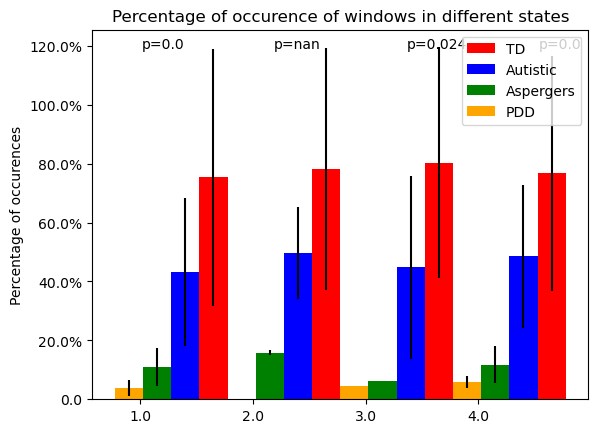

Successfully plotted !!!!


In [20]:
file_path = './Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat'
save_path = './Final/Outputs_cpac_NFNG/POC_Subtype_cpac_NFNG_K4.jpg'

poc_dict, p_dict = utils.get_poc(file_path, groups, n_states, n_windows_per_sub)
utils.plot_poc(poc_dict, p_dict, save_path)

## Analysis of State vector stats

In [21]:
cs = scipy.io.loadmat('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/Stats_K4/CPAC_NFNG__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


In [22]:
frac_time_states = cs['state_vector_stats'][0][0][0]
print("Shape of fraction time states : ", frac_time_states.shape)

Shape of fraction time states :  (365, 4)


['TD', 'Autistic', 'Aspergers', 'PDD']
Groups :  ['TD', 'Autistic', 'Aspergers', 'PDD']


/home/krishna/Downloads/MS_Thesis/VinceD/utils.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ytick_labels)


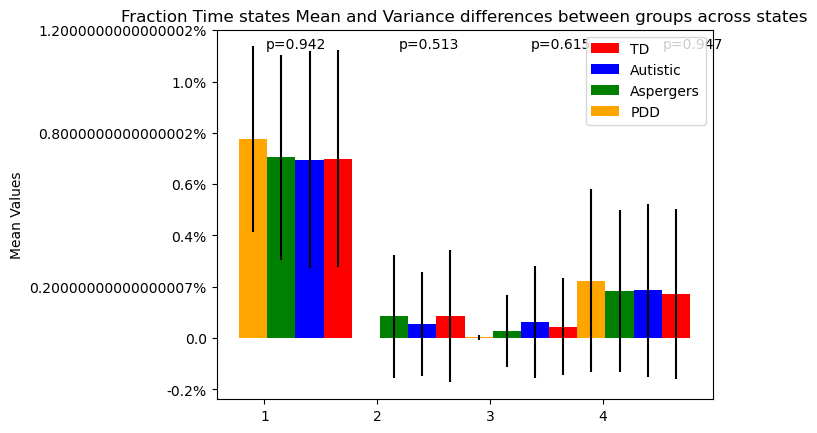

In [23]:
n_states = 4
pvalues_dict = utils.get_pvalues(frac_time_states, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(frac_time_states, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Fraction Time states')

In [24]:
mean_dwell_time = cs['state_vector_stats'][0][0][1]
print("Shape of fraction time states : ", mean_dwell_time.shape)

Shape of fraction time states :  (365, 4)


['TD', 'Autistic', 'Aspergers', 'PDD']
Groups :  ['TD', 'Autistic', 'Aspergers', 'PDD']


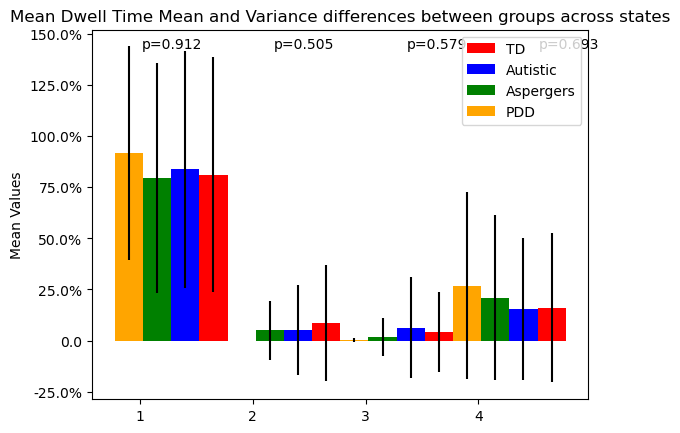

In [25]:
n_states = 4
pvalues_dict = utils.get_pvalues(mean_dwell_time, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(mean_dwell_time, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Mean Dwell Time')

Shape of fraction time states :  (365, 4, 4)


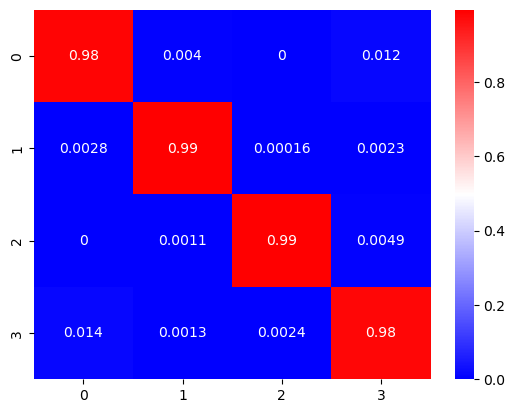

In [26]:
transition_matrix = cs['state_vector_stats'][0][0][2]
print("Shape of fraction time states : ", transition_matrix.shape)
transition_matrix_mean = np.mean(transition_matrix, axis = 0)
sns.heatmap(transition_matrix_mean, annot=True, cmap = 'bwr')
plt.show()
plt.close()

Mean of TD Transition matrix shape :  (4, 4)
Mean of Autistic Transition matrix shape :  (4, 4)
Mean of Aspergers Transition matrix shape :  (4, 4)
Mean of PDD Transition matrix shape :  (4, 4)


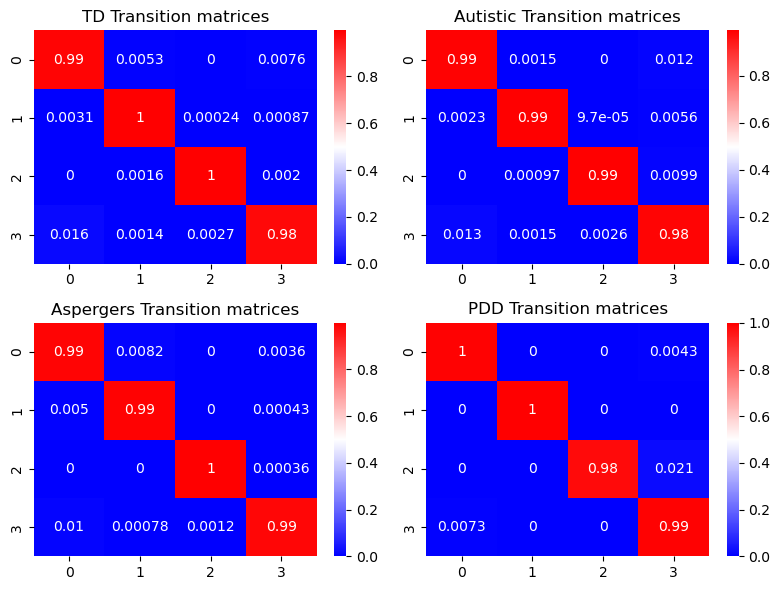

In [32]:
plt.subplots(2,2,  figsize=(8,6))
for index, group in enumerate(group_names): 
    plt.subplot(2,2, index+1)
    tm_mean = np.mean(transition_matrix[groups[group]], axis = 0)
    print(f'Mean of {group} Transition matrix shape : ', tm_mean.shape)
    sns.heatmap(tm_mean, annot=True, cmap = 'bwr')
    plt.title(f'{group} Transition matrices')
plt.tight_layout()
plt.show()
plt.close()


In [33]:
num_transitions = cs['state_vector_stats'][0][0][3]
print("Shape of fraction time states : ", num_transitions.shape)
nt1 = num_transitions[TD_idx, :]
nt2 = num_transitions[Autistic_idx, :]
nt3 = num_transitions[Aspergers_idx, :]
nt4 = num_transitions[PDDNOS_idx, :]
_, pvalue_nt = scipy.stats.f_oneway(nt1, nt2, nt3, nt4)
print('P-value of Number of transitions : ', pvalue_nt)

Shape of fraction time states :  (365, 1)
P-value of Number of transitions :  [0.93397293]
